### Possibly interesting features based on https://news.ycombinator.com/item?id=36590226
- Time of day [Done]
- how many posts 1 hr before post made (indicative of whether it's peak hour or not)
- Analysis on title: TF-IDF? Remove stopwords? Any other importance measures, and onehot encode the impt words?

In [1]:
import os

from pyspark.sql import SQLContext, Window
from pyspark.sql.functions import col,sum,desc,when,udf, percent_rank

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder, Tokenizer, StopWordsRemover, CountVectorizer, IDF, PCA

from datetime import datetime

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
# Load all folder names, then read into one textfile
file_path = "data/data/"
folders_names = [file_path + folder for folder in os.listdir(file_path) if "saved_stories" in folder]
compiled_stories = sc.textFile(','.join(folders_names[0:20]))
compiled_stories

data/data/saved_stories-1713285840000,data/data/saved_stories-1713286080000,data/data/saved_stories-1713286200000,data/data/saved_stories-1713286320000,data/data/saved_stories-1713286440000,data/data/saved_stories-1713286560000,data/data/saved_stories-1713286680000,data/data/saved_stories-1713286800000,data/data/saved_stories-1713286920000,data/data/saved_stories-1713287040000,data/data/saved_stories-1713287280000,data/data/saved_stories-1713292080000,data/data/saved_stories-1713292200000,data/data/saved_stories-1713292320000,data/data/saved_stories-1713292440000,data/data/saved_stories-1713292560000,data/data/saved_stories-1713292680000,data/data/saved_stories-1713292800000,data/data/saved_stories-1713292920000,data/data/saved_stories-1713293040000 MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [21]:
df = spark.read.json(compiled_stories)

In [22]:
# Convert frontpage to numeric
df = df.withColumn('frontpage', when(df.frontpage==True, 1).otherwise(0))

In [23]:
# Compile cleaning steps which cannot be fit into a pipeline. These steps will not cause data leakage
# Will have to be implemented on the script for doing streaming predictions

# Extracting type of post: Show HN
df = df.withColumn('isShowHN', when(df.title.contains("Show HN"), 1).otherwise(0))

# Extracting time of day
extract_time_of_day_udf = udf(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H'))


df = df.withColumn('time_of_day', extract_time_of_day_udf(df.posted_at))

# Extracting day of week
weekDay =  udf(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%w'))

df = df.withColumn('day_of_week', weekDay(df.posted_at))

### Modelling time

In [24]:
# Train test split based on time: Have to prevent data leakage. Sort dataframe by posted_at, and give a percentile rank allowing us to split
df = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("posted_at")))

train = df.where("rank <= .8").drop("rank")
test = df.where("rank > .8").drop("rank")

In [57]:
from pyspark.sql.functions import col

# Helper function to drop column if it exists
def drop_column_if_exists(df, col_name):
    return df.drop(col_name) if col_name in df.columns else df

# Fill null values
df = df.na.fill({"title": "", "source_title": "", "source_text": ""})

# If you would like to overwrite it
df = drop_column_if_exists(df, "title_tokens")
df = drop_column_if_exists(df, "title_filtered")
df = drop_column_if_exists(df, "source_title_tokens")
df = drop_column_if_exists(df, "source_title_filtered")
df = drop_column_if_exists(df, "rawFeatures")
df = drop_column_if_exists(df, "features")
df = drop_column_if_exists(df, "source_rawFeatures")
df = drop_column_if_exists(df, "source_features")

In [58]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, HashingTF
# 1. Tokenization
tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
df = tokenizer.transform(df)
tokenizer_source = Tokenizer(inputCol="source_title", outputCol="source_title_tokens")
df = tokenizer_source.transform(df)

# 2. Stop Word Removal
remover = StopWordsRemover(inputCol="title_tokens", outputCol="title_filtered")
df = remover.transform(df)
remover_source = StopWordsRemover(inputCol="source_title_tokens", outputCol="source_title_filtered")
df = remover_source.transform(df)

# 3. Hashing
hashingTF = HashingTF(inputCol="title_filtered", outputCol="rawFeatures", numFeatures=20)
df = hashingTF.transform(df)
hashingTF_source = HashingTF(inputCol="source_title_filtered", outputCol="source_rawFeatures", numFeatures=20)
df = hashingTF_source.transform(df)

# 4. TF-IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_source = IDF(inputCol="source_rawFeatures", outputCol="source_features")

In [59]:
# works faster when separating this part out
idfModel = idf.fit(df)
idfModel_source = idf_source.fit(df)
# need to concat the columns
rescaledData = idfModel.transform(df)
rescaledData = idfModel_source.transform(df)

In [60]:
rescaledData.printSchema()

root
 |-- aid: string (nullable = true)
 |-- comments: long (nullable = true)
 |-- domain: string (nullable = true)
 |-- frontpage: integer (nullable = false)
 |-- posted_at: string (nullable = true)
 |-- source_text: string (nullable = false)
 |-- source_title: string (nullable = false)
 |-- title: string (nullable = false)
 |-- url: string (nullable = true)
 |-- user: string (nullable = true)
 |-- votes: long (nullable = true)
 |-- isShowHN: integer (nullable = false)
 |-- time_of_day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- rank: double (nullable = false)
 |-- title_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- source_title_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- source_title_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: ve

In [61]:
rescaledData.select("source_features").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|source_features                                                                                                                                                                                       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(20,[2,3,9,11,15],[1.437175482663796,1.404740206910642,1.529194381384048,1.3733240106772633,1.4936876929271383])                                                                                      |
|(20,[4,15],[1.6305468756443355,1.4936876929271383])                                                                                                                                                

In [62]:
from pyspark.ml.feature import PCA
# Fit the PCA model
pca = PCA(k=11, inputCol="source_features", outputCol="source_pcaFeatures")
model = pca.fit(rescaledData)

In [43]:
# Explained variance by each principal component
explainedVariance = model.explainedVariance

In [44]:
explainedVariance

DenseVector([0.1173, 0.0941, 0.0791, 0.0698, 0.0609, 0.0561, 0.0543, 0.054, 0.0497, 0.0443])

In [46]:
# Determine the number of components needed to explain at least 85% of the variance
cumulativeVariance = explainedVariance.cumsum()
k = (cumulativeVariance < 0.85).sum() + 1

In [47]:
print(f"Number of components to explain 85% of variance: {k}")
print("Explained Variance per component:", explainedVariance)

Number of components to explain 85% of variance: 11
Explained Variance per component: [0.11732661649671437,0.09411526616667798,0.07906346615709779,0.06980513615967812,0.06089639153552773,0.05606035590636425,0.054260811249916566,0.05399939946117038,0.04973534728345808,0.044329624591909145]


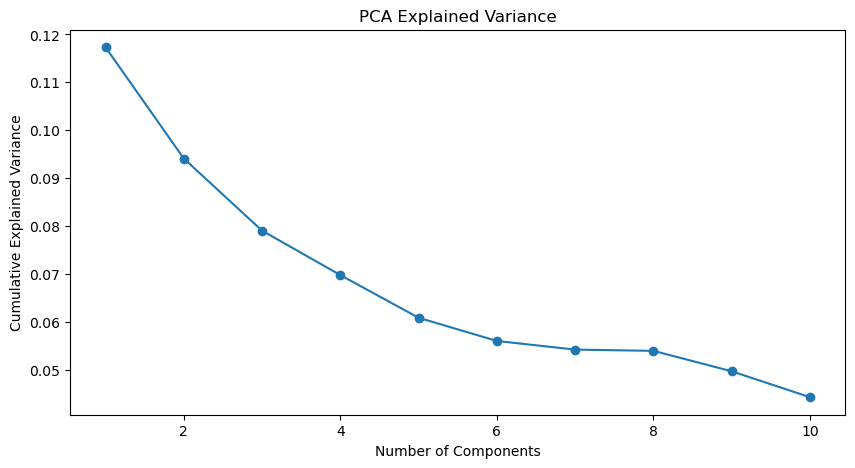

In [52]:
# Optionally, visualize the results if you are using a notebook that supports plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explainedVariance) + 1), explainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
#plt.grid(True)
plt.show()

In [52]:
# Define numerical, categorical and target columns. To adjust the column lists here which will feed into the processing later
NUM_COL = ['votes', 'comments']
CAT_COL = ['isShowHN', 'time_of_day', 'day_of_week']

In [58]:
# Other cleaning stages which can be fit into a pipeline. Will automatically apply all steps to test set

# Dealing with numerical variables
numerical_vector_assembler = VectorAssembler(inputCols=NUM_COL, outputCol='num_col_vector')
std_scaler = StandardScaler(inputCol='num_col_vector',
                            outputCol='scaled_num_col_vector',
                            withStd=True, withMean=True)

# Dealing with categorical variables
isShowHN_indexer = StringIndexer(inputCol='isShowHN',
                            outputCol='isShowHN_index')
isShowHN_ohe = OneHotEncoder(inputCol='isShowHN_index',
                                outputCol='isShowHN_OHE')

# To put all numerical vectors and onehotencoded categorical variables into the same final_feature_vector vector
overall_assembler = VectorAssembler(inputCols=['scaled_num_col_vector',
                                               'isShowHN_OHE'],
                                    outputCol='final_feature_vector')


In [79]:
# Initiate model(s) and params
lr = LogisticRegression(maxIter=100, family="binomial",
                        featuresCol='final_feature_vector', labelCol='frontpage',
                        weightCol="frontpage")

param_grid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.0, 0.1,0.5]) 
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) 
                .build())

rfc = RandomForestClassifier(maxDepth=30, seed=42, weightCol="frontpage")

param_grid_rfc = (ParamGridBuilder()
                .addGrid(rfc.numTrees, [10, 100]) 
                .addGrid(rfc.impurity, ['gini', 'entroopy']) 
                .build())

In [87]:
# Compile final pipelines
cleaning_stages = [numerical_vector_assembler,
                   std_scaler, 
                   isShowHN_indexer, 
                   isShowHN_ohe,
                   overall_assembler]
pipeline_lr = Pipeline(stages=cleaning_stages + [lr])
pipeline_rfc = Pipeline(stages=cleaning_stages + [rfc])

In [96]:
# Defining evaluator and crossvalidation object
evaluator = BinaryClassificationEvaluator().setLabelCol("frontpage")

# Join everything together using a CrossValidator object.
crossval_lr = CrossValidator(
    estimator=pipeline_lr, 
    estimatorParamMaps=param_grid_lr, 
    evaluator=evaluator, 
    numFolds=3,
    parallelism=4, 
    seed=42
)

In [97]:
# Training
cvModel = crossval_lr.fit(train)


24/05/09 19:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 1

KeyboardInterrupt: 

24/05/09 19:03:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:03:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 19:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 1

In [69]:
# Model evaluation
best_model = cvModel.bestModel
best_score = cvModel.avgMetrics[0]

print("Best model: ", best_model)
print("Best score: ", best_score)

Best model:  PipelineModel_eb506f5816f2
Best score:  0.9418476184285297


In [70]:
# Get best model
best_lr_params = best_model.stages[-1].extractParamMap()

print("Best score (RMSE):", best_score, end="\n\n")

for parameter, value in best_lr_params.items():
    print(f"{str(parameter):50s}, {value}")

Best score (RMSE): 0.9418476184285297

LogisticRegression_a34220c6c6c6__aggregationDepth , 2
LogisticRegression_a34220c6c6c6__elasticNetParam  , 1.0
LogisticRegression_a34220c6c6c6__family           , binomial
LogisticRegression_a34220c6c6c6__featuresCol      , final_feature_vector
LogisticRegression_a34220c6c6c6__fitIntercept     , True
LogisticRegression_a34220c6c6c6__labelCol         , frontpage
LogisticRegression_a34220c6c6c6__maxBlockSizeInMB , 0.0
LogisticRegression_a34220c6c6c6__maxIter          , 100
LogisticRegression_a34220c6c6c6__predictionCol    , prediction
LogisticRegression_a34220c6c6c6__probabilityCol   , probability
LogisticRegression_a34220c6c6c6__rawPredictionCol , rawPrediction
LogisticRegression_a34220c6c6c6__regParam         , 0.1
LogisticRegression_a34220c6c6c6__standardization  , True
LogisticRegression_a34220c6c6c6__threshold        , 0.5
LogisticRegression_a34220c6c6c6__tol              , 1e-06


In [72]:
# Test scores
test_pred = best_model.transform(test)

# show scores
print(evaluator.evaluate(test_pred))

24/05/09 17:27:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 17:27:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 17:27:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.9759615384615384


24/05/09 17:28:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/09 17:28:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [73]:
# save best model from cv grid search
mPath =  file_path+"models/best_model"
best_model.write().overwrite().save(mPath)